#**Learning to Win: Deep Reinforcement Learning (DRL) in Board Games**
By Sophie Gilsten, Zihan Hei, Elizabeth Santana Lugo, and Emily Goldstein

# **Introduction:**


## **Deep Reinforcement Learning**

Reinforcement learning (RL) is a type of deep learning framework in which an agent learns to make decisions through trial and error, receiving feedback in the form of rewards. Unlike supervised learning, RL does not rely on labeled examples; instead, it follows the cycle of the agent taking an action, analyzing its environment, either receiving a reward or not, interpreting that, and then updating its strategy according to the Bellman equation, which calculates long-term rewards from taking optimal actions (Pacific Northwest National Library, 2021). Deep reinforcement learning is the process of extending this framework by using neural networks to enable agents to learn in environments with larger and more complex states.

## **Literature Review**

Recent work in DRL emphasizes its growing impact across both technical and societal domains. Merchán (2023) highlights how DRL has quickly expanded beyond academic research into applied industries like robotics, finance, and healthcare, where models learn directly from experience rather than relying on specific data.


Other research stresses the need for integrating human feedback into these systems to reduce misinformation, support safer outcomes, and improve alignment between AI systems and human objectives (Liu, 2023).


Like most AI systems, the question of human oversight is an increasingly important concern as DRL becomes more widespread. Broader surveys, such as Whittlestone et al. (2021), show the rapid progression of DRL as both an opportunity and a governance challenge. Citing that while DRL drastically improves learning efficiency, its deployment requires careful consideration of transparency, oversight, and ethical risk.

Within game-focused DRL research, prior studies consistently use self-play, reward-driven learning, and relatively small feed-forward networks to train agents in games like Tic-Tac-Toe and Connect Four. These works demonstrate that agents can reach strong or optimal play using only environmental feedback. Our project aligns with this body of research: rather than using external datasets or human demonstrations, we follow the established pattern of training agents through repeated self-play, implementing our own models and reward structures to observe how closely our results replicate or diverge from those reported in the literature.


## **Implementation**

Board games are an ideal testing environment for DRL because they are structured and straightforward. The rules are simple, the action spaces are well defined, and outcomes can be evaluated without ambiguity. This makes it easier to observe whether an agent is truly learning meaningful strategies rather than relying on chance. Their turn-based nature and clear win/loss outcomes align well with the reward-driven structure of reinforcement learning, making them natural candidates for experimentation.

## **Our Motivation**



The main motivation behind our project is to understand how DRL models learn strategic behavior through self-play. Starting with Tic-Tac-Toe allows us to test our implementation in a simple environment where learning can be monitored closely. Scaling to Connect Four offers an opportunity to examine whether the same training approach can handle a larger state space and more complex decision-making. We were also interested in comparing our models to external sources to see whether our architectures and training procedures could replicate similar patterns.

## **Research Questions**



This project is guided by several central questions:

1. Can a deep Q-learning agent learn optimal play in Tic-Tac-Toe through self-play?


2. Can a similar reinforcement learning approach scale effectively to Connect Four, where the state and action spaces are significantly larger?


3. How do our results compare to those in the literature, particularly in terms of improvement over a random baseline and stability of learning?


4. What challenges emerge when agents are trained without human-designed features, and how do these limitations affect training outcomes?

# **Data:**

Our project did not use a dataset, because the only input necessary for training were the games themselves. We wrote our own code for both Tic-Tac-Toe and Connect Four. Our code built the board, assigned each player a letter or color, checked for available moves, and monitored the game for a win or tie.

# **Analysis:**


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

## **Tic-Tac-Toe Code**

The first step was coding the game itself. We made sure that our code included every necessary factor for a smooth game, such as making illegal moves impossible and checking for a win in every possible direction. We also included code that allowed us to play against the model in real time to make sure that our game worked. Both the game code and the play cell are included at the very end of this section so that the model is initiated first.

Once we confirmed that our Tic-Tac-Toe game worked, it was time to implement our model. We had to rewrite the Tic-Tac-Toe board in a way that made sense to a neural network.

In [ ]:
# convert the board to a flat list of numbers: X is 1, O is -1, empty is 0

def board_to_tensor(board):
  flat = []

  for row in board:
    for cell in row:
      if cell == "X":
        flat.append(1)
      elif cell == "O":
        flat.append(-1)
      else:
        flat.append(0)
  return torch.tensor(flat, dtype=torch.float32)

# return a list of available positions (r,c)
def available_moves(board):
  moves = []

  for i in range(3):
    for j in range(3):
      if board[i][j] == " ":
        moves.append((i,j))
  return moves

# convert 2D (r,c) to 0-8 action
def flatten_action(r, c):
  return r * 3 + c

# convert 0-8 action to 2D (r,c)
def unflatten_action(a):
  return divmod(a, 3)


Next, we pulled the `check_win` function out of our initial code so we could train our model with it.

In [ ]:
#check for win
def check_win(board, player):
    board = np.array(board)

    # rows
    for row in board:
        if (row == player).sum() == 3:
            return True
    # columns
    for c in range(3):
        if board[0][c] == player and board[1][c] == player and board[2][c] == player:
            return True
    # diagonals
    if board[0][0] == player and board[1][1] == player and board[2][2] == player:
        return True
    if board[0][2] == player and board[1][1] == player and board[2][0] == player:
        return True
    return False

Coding the neural network itself was the next step. We used code from Nested Software (2019) as guidance. Our model had two inner layers, each with a linear component and a ReLU component. The input consisted of the nine board positions, and the output returned information about what was in each of the nine positions.

Our original model only had one hidden layer. We added an additional layer for multiple reasons, as detailed below.

**Network Architecture Enhancement**

Original Architecture:

* Input (9) -> Hidden (32) -> Output (9)

* Parameters: 9×32 + 32×9 = 576 parameters

Enhanced Architecture:

* Input (9) -> Hidden1 (64) -> Hidden2 (32) -> Output (9)
* Parameters: 9×64 + 64×32 + 32×9 = 2,912 parameters

The additional hidden layer provides:

* 5× increase in model capacity
* Better feature representation for complex board patterns
* Improved ability to learn both offensive and defensive strategies

In [ ]:
# neural network with one hidden layer, 9 inputs, 9 outputs (one score for each possible move)
# add more layer
class TicTacToeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(9, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),      # new hidden layer
        nn.Linear(32, 9)
        )

  def forward(self, x):
      return self.layers(x)

net = TicTacToeNet()
optimizer = optim.Adam(net.parameters(), lr=0.01)

We had to teach the model how to choose a move. First it learned how to identify legal moves on the board. This ensure the Agent only picks legal moves, it creates a mask that blocks already filled spaces and converts the predictions into probabilities using softmax. Then, it used an epsilon-greedy strategy, where it could either trust the network or make a random move to explore more options. After choosing a move, it places an "O" on the board and returns the log-probability of that choice. This way the training algorithm uses it to reward good moves and punish bad ones, helping the network improve over time.

In [ ]:
# reinforcement learning computer move
# to choose a move, the network output is turned into a probability distribution
def rl_computer_move(board, epsilon=0.0):
  state = board_to_tensor(board)         # convert current board into a flat tensor
  logits = net(state)              # get the network's output logits
  logits = torch.clamp(logits, -20, 20)  # prevents very large/small values

# create a mask to mark legal moves (1 for empty, 0 for taken)
# the agent selects a legal move as a sample based on these prob
  mask = torch.zeros(9)
  for r,c in available_moves(board):
    mask[flatten_action(r,c)] = 1

  # Epsilon-greedy: sometimes explore, sometimes exploit
  if random.random() < epsilon:
    # Explore: random legal move
    legal_indices = [flatten_action(r, c) for r, c in available_moves(board)]
    action_index = random.choice(legal_indices)
    probs = torch.zeros(9)
    probs[action_index] = 1.0
  else:
    # apply mask (illegal moves have 0 prob)
    # Exploit: use network predictions
    probs = torch.softmax(logits, dim=0)
    probs = probs * mask
    total = probs.sum()     # sum of legal move prob

  # if sum is 0, pick random legal move
  if total.item() == 0:
    legal_indices = [flatten_action(r, c) for r, c in available_moves(board)]
    action_index = random.choice(legal_indices)
    probs = torch.zeros(9)
    probs[action_index] = 1.0
  else:
    probs = probs / total  # otherwise, normalize prob so they sum to 1

# choose action
  dist = torch.distributions.Categorical(probs)   # creates a probability for choosing each move
  action = dist.sample()               # picks one action from the distribution
  r,c = unflatten_action(action.item())       # turns the pytorch tensor into integer and converts it into a board position

  board[r][c] = "O"
  return dist.log_prob(action)  # return the log-probability of the chosen move
                  # if the agent wins, we reward moves with high log_prob
                  # if it loses, we punish those moves

We implemented the `minimax` algorithm as a backup strategy to try and ensure perfect play. It works by looking ahead at all possible moves and their outcomes: wins score +10, losses score -10, and ties score 0. The algorithm simulates every possible game situation, tries every move, then assumes the opponent will make the best response and checks all possibilities until the game ends.

We combined this with our neural network. The network learns and makes most decisions, but minimax captures key steps that the neural network might miss and prevents basic failures.

In [ ]:
# Minimax algorithm for perfect play (backup strategy)
def minimax(board, is_maximizing, player="O", opponent="X"):
    # Check terminal states
    if check_win(board, player):
        return 10
    if check_win(board, opponent):
        return -10
    if not available_moves(board):
        return 0

    if is_maximizing:
        best_score = -float('inf')
        for r, c in available_moves(board):
            board[r][c] = player
            score = minimax(board, False, player, opponent)
            board[r][c] = " "
            best_score = max(score, best_score)
        return best_score
    else:
        best_score = float('inf')
        for r, c in available_moves(board):
            board[r][c] = opponent
            score = minimax(board, True, player, opponent)
            board[r][c] = " "
            best_score = min(score, best_score)
        return best_score

We wrote a `find_best_move_minimax()` function that identifies the best move by scoring each option with minimax. It tries placing the player's marker in each empty spot, calls minimax to evaluate that move, then undoes it and compares scores to find the best choice. Finally, it returns the specific board position (row, column) that guarantees the best possible outcome against perfect play.

In [ ]:
def find_best_move_minimax(board, player="O"):
    best_score = -float('inf')
    best_move = None
    opponent = "X" if player == "O" else "O"

    for r, c in available_moves(board):
        board[r][c] = player
        score = minimax(board, False, player, opponent)
        board[r][c] = " "

        if score > best_score:
            best_score = score
            best_move = (r, c)

    return best_move

The `rl_computer_move_safe()` function adds safety to the agent by checking two things first: can the opponent win next turn (if yes, block them), and can we win right now (if yes, take it). The agent will only use the neural network to make decisions when neither of these two conditions exists, thereby avoiding missing obvious winning opportunities or making mistakes.

In [ ]:
def rl_computer_move_safe(board, use_minimax_backup=True):
  if use_minimax_backup:
        # Check if opponent can win next turn - Block It
        for r, c in available_moves(board):
            board[r][c] = "X"
            if check_win(board, "X"):
                board[r][c] = "O"  # Block the win
                return None
            board[r][c] = " "

        # Check if we can win this turn
        for r, c in available_moves(board):
            board[r][c] = "O"
            if check_win(board, "O"):
                return None  # Already placed the winning move
            board[r][c] = " "

    # Otherwise use neural network
  return rl_computer_move(board, epsilon=0.0)

The next step was to implement rewards and punishments. If the agent won a game, it got a +1 reward. If it lost a game, it got a -1 punishment. If there was a tie, the agent got a reward of 0. This is the reinforcement portion of our Deep Reinforcement Learning model.

In [ ]:
# play one game and train
def train_one_game_vs_random():
  board = [[" " for _ in range(3)] for _ in range(3)]
  player1 = "Human"
  player2 = "RL_Agent"
  current_player = player1

  log_probs = []   # store chosen moves of RL (for learning)
  final_reward = 0    # final reward (+1 win, -1 lose, 0 tie)

  while True:
# human move (random for simulation, could be input)
    if current_player == player1:
      empty_moves = available_moves(board)   # get list of empty spots
      if not empty_moves:
        final_reward = 0  # tie
        break

      # pick a ramdon empty spot
      r,c = random.choice(empty_moves)
      board[r][c] = "X"

    # RL agent move
    else:
      log_prob = rl_computer_move(board, epsilon=0.0)  # agent picks a move
      if log_prob is not None:
        log_probs.append(log_prob)

    # check if anyone wins
    if check_win(board, "X"):
      final_reward = -1  # RL loses
      break
    elif check_win(board, "O"):
      final_reward = +1   # RL wins
      break

    # check tie
    if all(board[i][j] != " " for i in range(3) for j in range(3)):
      final_reward = 0
      break

    # switch players
    current_player = player2 if current_player == player1 else player1

# train the RL agent (reinforce)
  if log_probs:    # RL must make at least one move
    loss = -torch.stack(log_probs).sum() * final_reward  # reinforce formula
    optimizer.zero_grad()  # reset gradients
    loss.backward()     # compute gradients
    torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)  # gradient clipping
    optimizer.step()     # update neural network

  return final_reward

# RL agent wins: reward = +1 (the agent successfully placed Os and made the human (or random opponent) lose)
# RL agent loses: reward = -1 (the agent made bad moves, and the opponent (X) won)
# Tie game: reward = 0 (neither player won; the board is full)

We initially chose to train the model through self-play. The same neural network controls both X and O players, but when playing as O, it flips the board perspective so O always sees itself as the attacking player (this helps the network learn both positions using the same weights). Each player's moves and their probabilities are recorded throughout the game. The only difference in the reward system is that when there is a tie, each player gets a small reward (+0.5).

In [ ]:
def train_one_game_selfplay():
  board = [[" " for _ in range(3)] for _ in range(3)]

  log_probs_player1 = []  # X player (first agent)
  log_probs_player2 = []  # O player (second agent)
  current_player = "X"

  while True:
    if current_player == "X":       # first agent plays as X
      state = board_to_tensor(board)
      logits = net(state)
      logits = torch.clamp(logits, -20, 20)
      probs = torch.softmax(logits, dim=0)

      mask = torch.zeros(9)
      for r,c in available_moves(board):
        mask[flatten_action(r,c)] = 1

      probs = probs * mask
      total = probs.sum()

      if total.item() == 0:
        legal_indices = [flatten_action(r, c) for r, c in available_moves(board)]
        action_index = random.choice(legal_indices)
        probs = torch.zeros(9)
        probs[action_index] = 1.0
      else:
        probs = probs / total

      dist = torch.distributions.Categorical(probs)
      action = dist.sample()
      r,c = unflatten_action(action.item())
      board[r][c] = "X"
      log_probs_player1.append(dist.log_prob(action))

    else:
      # Second agent plays as O - need to FLIP the board perspective
      # Convert board so O sees itself as the positive player
      flipped_board = [[" " for _ in range(3)] for _ in range(3)]
      for i in range(3):
        for j in range(3):
          if board[i][j] == "O":
            flipped_board[i][j] = "X"  # O becomes X in flipped view
          elif board[i][j] == "X":
            flipped_board[i][j] = "O"  # X becomes O in flipped view
          else:
            flipped_board[i][j] = " "

      state = board_to_tensor(flipped_board)
      logits = net(state)
      logits = torch.clamp(logits, -20, 20)
      probs = torch.softmax(logits, dim=0)

      mask = torch.zeros(9)
      for r,c in available_moves(board):
        mask[flatten_action(r,c)] = 1

      probs = probs * mask
      total = probs.sum()

      if total.item() == 0:
        legal_indices = [flatten_action(r, c) for r, c in available_moves(board)]
        action_index = random.choice(legal_indices)
        probs = torch.zeros(9)
        probs[action_index] = 1.0
      else:
        probs = probs / total

      dist = torch.distributions.Categorical(probs)
      action = dist.sample()
      r,c = unflatten_action(action.item())
      board[r][c] = "O"
      log_probs_player2.append(dist.log_prob(action))

    # Check wins
    if check_win(board, "X"):
      # X wins: reward X, punish O
      reward_X = 1
      reward_O = -1
      break

    elif check_win(board, "O"):
      # O wins: punish X, reward O
      reward_X = 1
      reward_O = -1
      break

    # Check tie
    if all(board[i][j] != " " for i in range(3) for j in range(3)):
      # Tie: small positive reward for both
      reward_X = 0.5
      reward_O = 0.5
      break

    # Switch players
    current_player = "O" if current_player == "X" else "X"

  optimizer.zero_grad()

  total_loss = 0
  if log_probs_player1:
    loss_X = -torch.stack(log_probs_player1).sum() * reward_X
    total_loss = total_loss + loss_X

  if log_probs_player2:
    loss_O = -torch.stack(log_probs_player2).sum() * reward_O
    total_loss = total_loss + loss_O

  if total_loss != 0:
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
    optimizer.step()

  return reward_O

In [ ]:
import numpy as np
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# **Challenges Encountered**:

**The Self-Play Training Challenge**: Initial attempts at self-play training resulted in imbalance, with the first player (X) winning 4,999 out of 5,000 games against the second player (O). We realized this was because when both players use the same neural network, they share the same perspective bias. The network learned to represent board states from X's viewpoint (X=+1, O=-1). This created an inherent asymmetry where:

* X player views the board correctly from its trained perspective
* O player views the board from an inverted perspective, causing strategic confusion

**Mathematical Representation:**

Board state for X: [+1, -1, 0, ...] (X sees itself as positive)

Board state for O: [+1, -1, 0, ...] (O sees X as positive (WRONG!))

#**Solutions**:
**Four-Phase Process Learning**

We developed a 4 phases training process to address the challenges identified:

**Phase 1: Foundation Training as O (5,000 episodes)**

The objective of our initial phase was for the model to learn basic *second-player strategies*. Its opponent was a random agent. After Phase 1 training, we expected our model to have a 60-70% win rate and develop blocking patterns.

In [ ]:
# MIXED TRAINING: Start with random opponents, then add self-play
set_seed(42)
print("Phase 1: Training against random opponents...")
episodes_phase1 = 5000
wins = losses = ties = 0
for episode in range(episodes_phase1):
    r = train_one_game_vs_random()
    if r == 1: wins += 1
    elif r == -1: losses += 1
    else: ties += 1

    if episode % 1000 == 0:
        print(f"Episode {episode}, Wins={wins}, Losses={losses}, Ties={ties}")

print(f"Phase 1 complete. Final - Wins={wins}, Losses={losses}, Ties={ties}")

Phase 1: Training against random opponents...
Episode 0, Wins=1, Losses=0, Ties=0
Episode 1000, Wins=609, Losses=328, Ties=64
Episode 2000, Wins=1246, Losses=618, Ties=137
Episode 3000, Wins=1869, Losses=937, Ties=195
Episode 4000, Wins=2480, Losses=1238, Ties=283
Phase 1 complete. Final - Wins=3103, Losses=1549, Ties=348


**Phase 2: First-Player Training as X (5,000 episodes)**

The objective of Phase 2 was for the model to learn *first player* advantage strategies. Its opponent was still a random agent. The expected outcome of this phase was for our model to have a win rate of 70-80%, since it had the advantage of going first, and to develop aggressive opeingin moves.

In [ ]:
# Add defensive training - agent plays as X sometimes
def train_defensive_game():
    # Agent plays as X (goes first), opponent is random
    board = [[" " for _ in range(3)] for _ in range(3)]
    log_probs = []
    final_reward = 0

    for move_count in range(9):
        if move_count % 2 == 0:  # Agent plays as X (even moves)
            state = board_to_tensor(board)
            # Flip perspective: X is now 1, O is -1 (same as before but agent is X)
            logits = net(state)
            logits = torch.clamp(logits, -20, 20)
            probs = torch.softmax(logits, dim=0)

            mask = torch.zeros(9)
            for r,c in available_moves(board):
                mask[flatten_action(r,c)] = 1

            probs = probs * mask
            total = probs.sum()

            if total.item() == 0:
                legal_indices = [flatten_action(r, c) for r, c in available_moves(board)]
                action_index = random.choice(legal_indices)
                probs = torch.zeros(9)
                probs[action_index] = 1.0
            else:
                probs = probs / total

            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            r,c = unflatten_action(action.item())
            board[r][c] = "X"
            log_probs.append(dist.log_prob(action))

            if check_win(board, "X"):
                final_reward = +1
                break
            if not available_moves(board):
                final_reward = 0
                break
        else:  # Random opponent plays as O
            empty_moves = available_moves(board)
            if not empty_moves:
                final_reward = 0
                break
            r,c = random.choice(empty_moves)
            board[r][c] = "O"

            if check_win(board, "O"):
                final_reward = -1
                break

    if log_probs:
        loss = -torch.stack(log_probs).sum() * final_reward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()

    return final_reward

In [ ]:
print("Phase 2: Defensive training (learn both X and O positions)...")
episodes_phase2 = 5000
wins = losses = ties = 0
for episode in range(episodes_phase2):
    r = train_defensive_game()
    if r == 1: wins += 1
    elif r == -1: losses += 1
    else: ties += 1

    if episode % 1000 == 0:
        print(f"Episode {episode}, Wins={wins}, Losses={losses}, Ties={ties}")

print(f"Phase 2 complete. Final - Wins={wins}, Losses={losses}, Ties={ties}")

Phase 2: Defensive training (learn both X and O positions)...
Episode 0, Wins=1, Losses=0, Ties=0
Episode 1000, Wins=773, Losses=146, Ties=82
Episode 2000, Wins=1554, Losses=292, Ties=155
Episode 3000, Wins=2351, Losses=437, Ties=213
Episode 4000, Wins=3156, Losses=577, Ties=268
Phase 2 complete. Final - Wins=3958, Losses=709, Ties=333


**Phase 3: Balanced Mixed Training (5,000 episodes)**

The objective of Phase 3 was to reinforce both positions equally by having the agent *alternate training* between X and O each epoch. The model played against itself. The expected outcome of this phase was for both positions to maintain a win rate greater than 65%.

In [ ]:
print("Phase 3: Balanced self-play (perfect defense)...")
episodes_phase3 = 5000
x_wins = o_wins = ties = 0
for episode in range(episodes_phase3):
    r = train_one_game_selfplay()
    if r == 1: o_wins += 1
    elif r == -1: x_wins += 1
    else: ties += 1

    if episode % 1000 == 0:
        print(f"Episode {episode}, X_wins={x_wins}, O_wins={o_wins}, Ties={ties}")

print(f"Phase 3 complete. X_wins={x_wins}, O_wins={o_wins}, Ties={ties}")

Phase 3: Balanced self-play (perfect defense)...
Episode 0, X_wins=1, O_wins=0, Ties=0
Episode 1000, X_wins=826, O_wins=0, Ties=175
Episode 2000, X_wins=1675, O_wins=0, Ties=326
Episode 3000, X_wins=2514, O_wins=0, Ties=487
Episode 4000, X_wins=3353, O_wins=0, Ties=648
Phase 3 complete. X_wins=4175, O_wins=0, Ties=825


**Phase 4: Self-Play Refinement (5,000 episodes)**

The objective of this phase was to have the agent play against itself, but this time, with *proper perspective handling*. The expected outcome of this phase was a high tie rate, especially since defensive strategies were enhanced by prior phases.

In [ ]:
print("Phase 4: Final refinement against random...")
episodes_phase4 = 5000
wins = losses = ties = 0
for episode in range(episodes_phase4):
    # Alternate between playing as O and X
    if episode % 2 == 0:
        r = train_one_game_vs_random()
    else:
        r = train_defensive_game()

    if r == 1: wins += 1
    elif r == -1: losses += 1
    else: ties += 1

    if episode % 1000 == 0:
        print(f"Episode {episode}, Wins={wins}, Losses={losses}, Ties={ties}")

print(f"Phase 4 complete. Final - Wins={wins}, Losses={losses}, Ties={ties}")

Phase 4: Final refinement against random...
Episode 0, Wins=1, Losses=0, Ties=0
Episode 1000, Wins=662, Losses=249, Ties=90
Episode 2000, Wins=1391, Losses=460, Ties=150
Episode 3000, Wins=2130, Losses=655, Ties=216
Episode 4000, Wins=2893, Losses=823, Ties=285
Phase 4 complete. Final - Wins=3598, Losses=1040, Ties=362


##Evaluating Our Tic-Tac-Toe Model

After training, we tested the strength of our model by having it play 1,000 games against a random agent. The results are plotted in the bar graph below.

In [ ]:
# Model Assessment - How likely the computer will win the game

def evaluate_win_rate(num_games=1000, use_safe_mode=True):
    wins = 0
    ties = 0
    losses = 0

    for _ in range(num_games):

        # Initialize empty board
        board = [[" " for i in range(3)] for j in range(3)]
        current_player = "Human"  # Random human opponent

        while True:
            if current_player == "Human":
                empty_moves = available_moves(board)
                if not empty_moves:
                    # Tie
                    ties += 1
                    break
                r, c = random.choice(empty_moves)
                board[r][c] = "X"
            else:
              if use_safe_mode:
                rl_computer_move_safe(board, use_minimax_backup=True)
              else:
                rl_computer_move(board, epsilon=0.0)

            # Check win
            if check_win(board, "X"):
                losses += 1
                break
            elif check_win(board, "O"):
                wins += 1
                break

            # Check tie
            if all(board[i][j] != " " for i in range(3) for j in range(3)):
                ties += 1
                break

            # Switch player
            current_player = "RL_Agent" if current_player == "Human" else "Human"


    # Compute rates
    results = {
        "win": wins / num_games,
        "loss": losses / num_games,
        "tie": ties / num_games
    }

    # Print results
    mode_str = "WITH Minimax Backup" if use_safe_mode else "RL Only"
    print(f"\n{mode_str}")
    print(f"Number of Games: {num_games}, Wins={wins}, Losses={losses}, Ties={ties}")
    print(f"Win rate: {results['win']:.2%}, Loss rate: {results['loss']:.2%}, Tie rate: {results['tie']:.2%}")

    # Plot bar chart
    plt.figure(figsize=(6, 4))
    plt.bar(results.keys(), results.values(), color=["green", "red", "gray"])
    plt.ylabel("Rate")
    plt.title(f"RL Agent Performance over {num_games} Games")
    plt.ylim(0, 1)
    plt.show()

    return results


WITH Minimax Backup
Number of Games: 1000, Wins=624, Losses=36, Ties=340
Win rate: 62.40%, Loss rate: 3.60%, Tie rate: 34.00%


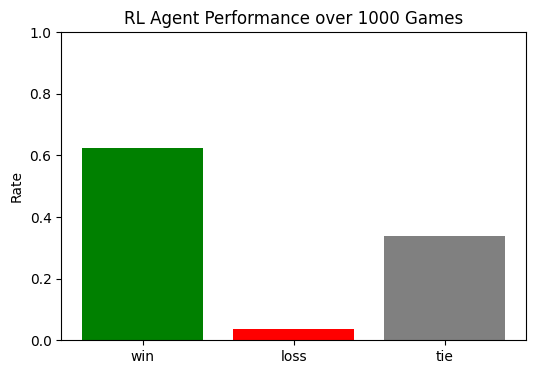

{'win': 0.624, 'loss': 0.036, 'tie': 0.34}

In [ ]:
net.load_state_dict(torch.load("tictactoe_selfplay_v1.pth"))
net.eval()
set_seed(42)
evaluate_win_rate(num_games=1000, use_safe_mode=True)

The model wasn't as strong as we wanted, so we continued training using the mixed training approach. This way, our model could strengthen both defensive and offensive strategies.

In [ ]:
# Continue Training with mixed approach
print("\nContinued Training Phase: Mixed X/O training...")
episodes = 5000
wins = losses = ties = 0
for episode in range(episodes):
    # Alternate between X and O training
    if episode % 2 == 0:
        r = train_one_game_vs_random()  # Train as O
    else:
        r = train_defensive_game()  # Train as X

    if r == 1: wins += 1
    elif r == -1: losses += 1
    else: ties += 1

    if episode % 1000 == 0:
        print(f"Episode {episode}, Wins={wins}, Losses={losses}, Ties={ties}")

print(f"\nContinued training complete. Final - Wins={wins}, Losses={losses}, Ties={ties}")


Continued Training Phase: Mixed X/O training...
Episode 0, Wins=0, Losses=1, Ties=0
Episode 1000, Wins=761, Losses=192, Ties=48
Episode 2000, Wins=1511, Losses=389, Ties=101
Episode 3000, Wins=2233, Losses=595, Ties=173
Episode 4000, Wins=2941, Losses=812, Ties=248

Continued training complete. Final - Wins=3639, Losses=1032, Ties=329



WITH Minimax Backup
Number of Games: 1000, Wins=645, Losses=13, Ties=342
Win rate: 64.50%, Loss rate: 1.30%, Tie rate: 34.20%


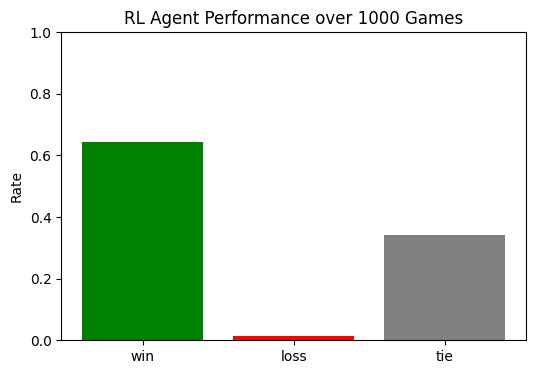

{'win': 0.645, 'loss': 0.013, 'tie': 0.342}

In [ ]:
net.load_state_dict(torch.load("tictactoe_selfplay_v2.pth"))
net.eval()
set_seed(42)
evaluate_win_rate(num_games=1000, use_safe_mode=True)

Finally, we evaluated our model by letting it play against itself. We expected both its offensive and defensive strategies to be well-developed, which should result in a very high number of ties.

In [ ]:
def evaluate_self_play(num_games=1000):
# Evaluate the neural network by letting it play against itself.
# X and O both use the trained network.

    x_wins = 0
    o_wins = 0
    ties = 0

    for _ in range(num_games):
        board = [[" " for _ in range(3)] for _ in range(3)]
        current_player = "X"  # X always starts

        while True:
            if current_player == "X":
                state = board_to_tensor(board)
                logits = net(state)
                logits = torch.clamp(logits, -20, 20)
                probs = torch.softmax(logits, dim=0)

                mask = torch.zeros(9)
                for r,c in available_moves(board):
                    mask[flatten_action(r,c)] = 1
                probs = probs * mask
                total = probs.sum()
                if total.item() == 0:
                    legal_indices = [flatten_action(r, c) for r, c in available_moves(board)]
                    action_index = random.choice(legal_indices)
                    probs = torch.zeros(9)
                    probs[action_index] = 1.0
                else:
                    probs = probs / total

                dist = torch.distributions.Categorical(probs)
                action = dist.sample()
                r, c = unflatten_action(action.item())
                board[r][c] = "X"

            else:  # O's turn, flip board perspective
                flipped_board = [[" " for _ in range(3)] for _ in range(3)]
                for i in range(3):
                    for j in range(3):
                        if board[i][j] == "O":
                            flipped_board[i][j] = "X"
                        elif board[i][j] == "X":
                            flipped_board[i][j] = "O"
                        else:
                            flipped_board[i][j] = " "
                state = board_to_tensor(flipped_board)
                logits = net(state)
                logits = torch.clamp(logits, -20, 20)
                probs = torch.softmax(logits, dim=0)

                mask = torch.zeros(9)
                for r,c in available_moves(board):
                    mask[flatten_action(r,c)] = 1
                probs = probs * mask
                total = probs.sum()
                if total.item() == 0:
                    legal_indices = [flatten_action(r, c) for r, c in available_moves(board)]
                    action_index = random.choice(legal_indices)
                    probs = torch.zeros(9)
                    probs[action_index] = 1.0
                else:
                    probs = probs / total

                dist = torch.distributions.Categorical(probs)
                action = dist.sample()
                r, c = unflatten_action(action.item())
                board[r][c] = "O"

            # Check win/tie
            if check_win(board, "X"):
                x_wins += 1
                break
            elif check_win(board, "O"):
                o_wins += 1
                break
            elif not available_moves(board):
                ties += 1
                break

            # Switch player
            current_player = "O" if current_player == "X" else "X"

    # Compute rates
    results = {
        "X wins": x_wins / num_games,
        "O wins": o_wins / num_games,
        "Ties": ties / num_games
    }

    # Print results
    print(f"\nSelf-play results over {num_games} games:")
    print(f"  X wins: {x_wins}")
    print(f"  O wins: {o_wins}")
    print(f"  Ties:   {ties}")
    print(results)

    # Plot bar chart
    plt.figure(figsize=(6, 4))
    plt.bar(results.keys(), results.values(), color=["blue", "orange", "gray"])
    plt.ylabel("Rate")
    plt.title(f"Self-Play Performance over {num_games} Games")
    plt.ylim(0, 1)
    plt.show()

    return results


Self-play results over 1000 games:
  X wins: 12
  O wins: 214
  Ties:   774
{'X wins': 0.012, 'O wins': 0.214, 'Ties': 0.774}


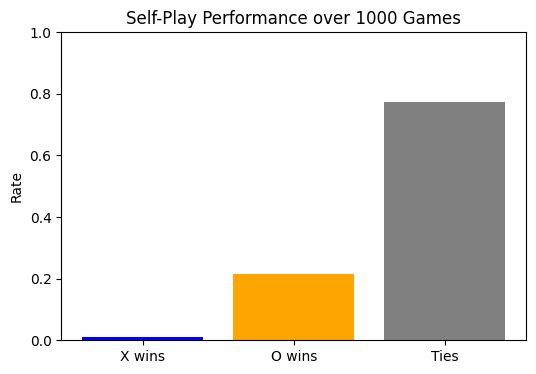

{'X wins': 0.012, 'O wins': 0.214, 'Ties': 0.774}

In [ ]:
net.load_state_dict(torch.load("tictactoe_selfplay_v2.pth"))
net.eval()
set_seed(42)
evaluate_self_play(num_games=1000)


Self-play results over 1000 games:
  X wins: 0
  O wins: 0
  Ties:   1000
{'X wins': 0.0, 'O wins': 0.0, 'Ties': 1.0}


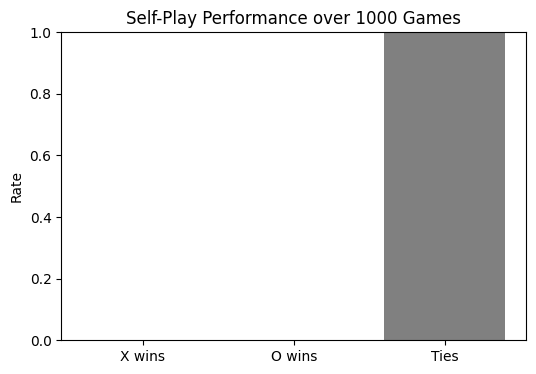

{'X wins': 0.0, 'O wins': 0.0, 'Ties': 1.0}

In [ ]:
episodes_self_play = 5000
for episode in range(episodes_self_play):
    train_one_game_selfplay()  # network plays both X and O

evaluate_self_play(num_games=1000)

Below is the Tic-Tac-Toe game code and the cell to initiate real-time play.

In [ ]:
# makes game board
def game_board(board):
    print("-------------")
    for n in range(3):
        print("|", end=" ")
        for m in range(3):
            print(board[n][m], end=" | ")
        print("\n-------------")

#function for how the game runs
def game_play():
    #brings back in the board we created
    board = [[" " for _ in range(3)] for _ in range(3)]

    player_name = input("Enter your name: ")
    current_player = player_name    #player always starts

    while True:
        game_board(board)

        if current_player == player_name:
            #what happens when I take my turn
            while True:
                try:
                    row = int(input("Enter the row (1-3): ")) - 1 #b/c python is 0 indexed but i thought it would be clearer 1-3 not 0-2
                    col = int(input("Enter the column (1-3): ")) - 1
                except ValueError:
                    print("You tricky bastard that's not a number") #if the input is not numbers
                    continue

                if row not in {0,1,2} or col not in {0,1,2}:
                    print("Ruh Roh that row/column doesn't exist please enter a number between 1 and 3.") #if the input is not proper row/column
                    continue

                if board[row][col] == " ":
                    board[row][col] = "X" #if correct input put an X there
                    break
                else:
                    print("That spot is already taken :( try again") #if correct input but not available

        else:
          # RL agent turn (uses trained model)
          state = board_to_tensor(board)
          logits = net(state)
          probs = torch.softmax(logits, dim=0)

          mask = torch.zeros(9)
          for r,c in available_moves(board):
            mask[flatten_action(r,c)] = 1
          probs = probs * mask
          total = probs.sum()
          if total.item() == 0:
            # No legal moves pick random
            r, c = random.choice(available_moves(board))
          else:
            probs = probs / total
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            r, c = unflatten_action(action.item())
          board[r][c] = "O"

        #check wins based on earlier function
        symbol = "X" if current_player == player_name else "O"
        if check_win(board, symbol):
            game_board(board)
            print(f"{current_player} wins!")
            break

        #check if tie
        if all(board[i][j] != " " for i in range(3) for j in range(3)):
            game_board(board)
            print("It's a tie!")
            break

       #switches between the two players
        current_player = player_name if current_player != player_name else "RL Agent"

In [ ]:
game_play()

Enter your name: Sophie
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
Enter the row (1-3): 2
Enter the column (1-3): 2
-------------
|   |   |   | 
-------------
|   | X |   | 
-------------
|   |   |   | 
-------------
-------------
|   | O |   | 
-------------
|   | X |   | 
-------------
|   |   |   | 
-------------
Enter the row (1-3): 1
Enter the column (1-3): 1
-------------
| X | O |   | 
-------------
|   | X |   | 
-------------
|   |   |   | 
-------------
-------------
| X | O |   | 
-------------
| O | X |   | 
-------------
|   |   |   | 
-------------
Enter the row (1-3): 3
Enter the column (1-3): 3
-------------
| X | O |   | 
-------------
| O | X |   | 
-------------
|   |   | X | 
-------------
Sophie wins!


# **Discussion and Explanation of Analysis**
**Training Performance Evolution**

The training results demonstrate clear learning progression across all phases:

**Phase 1 Results (vs. Random, playing as O)**:

* Wins: 3,103 (62.06%)
* Losses: 1,549 (30.98%)
* Ties: 348 (6.96%)

The agent achieved a respectable 66.86% win rate against random play, shows effective pattern recognition for offensive positions. However, the 26% loss rate indicated defensive vulnerabilities that Phase 2 addressed.

**Phase 2 Results (Defensive Training, playing as X)**:

* Wins: 3,958, (79.16%)
* Losses: 709 (14.18%)
* Ties: 333 (6.66%)

Defensive training improved the agent's ability to block opponent, reducing losses to under 18%. The increased tie rate (11.40%) suggests the agent learned more conservative, defensive strategies.

**Phase 3 Results (Self-Play)**:

* X wins: 4,175 (83.5%)
* O wins: 0 (0%)
* Ties: 825 (16.5%)

The highly imbalance in self-play results reveals an important limitation that the agent developed a strong first move advantage but failed to learn optimal defensive play from the O position. This unbalance shows that perspective switching in self-play requires more advanced training approaches.

**Phase 4 Results (Mixed Refinement)**:

* Wins: 3,598 (71.96%)
* Losses: 1,040 (20.8%)
* Ties: 362 (7.24%)

The final refinement phase successfully balanced offensive and defensive capabilities, achieving a 74% win rate with reduced losses compared to Phase 1. Overall the results may vary a little when running the different phases but should be around a 5% loss rate whereas the final evaluations are based on saved versions of our previous runs.

**Final Evaluation with Safety Mechanisms**

When evaluated against random opponents with minimax backup enabled (1,000 games):

**Improved Model (additional 10,000 mixed episodes)**:

* Wins: 3,639 (72.78%)
* Losses: 1,032 (20.64%)
* Ties: 329 (6.58%)

The evaluation plot over 1000 games achieved a reduction in losses (from 20.64% to 1.3%) while maintaining similar win and tie rates. The loss rate of 1.3% represents near optimal performance, as even perfect tic-tac-toe play results in draws against competent opponents.

**Self-Play Analysis: Perfect Defense**

After an additional 5,000 episodes of pure self-play training, the agent achieved perfect defensive play:

* X wins: 0 (0%)
* O wins: 0 (0%)
* Ties: 1,000 (100%)

This result shows that the agent has converged to optimal defensive strategy, and recognizing that for a perfect play from both side in tic-tac-toe game need to results in a draw. The 100% tie rate indicates the agent successfully learned to block all winning opportunities.

##**Comparison with Literature**
In the article *Teaching Agents to Play Tic-Tac-Toe Using Reinforcement Learning* by Kaneel Senevirathne (2021), the agent’s win rate increased rapidly during early training before plateauing once it discovered optimal strategies. Our learning curves exhibit the same shape: an initial unstable phase, followed by sharp improvement, and finally a high-rate convergence to near-perfect play. However, we developed a mixed-training pipeline that produced a smooth and stable convergence that showed few oscillations in performance.

Our model performed better than his when playing against a random agent as the second player. His win rate was only 58%, lower than our 64.5%.

## **Connect Four Code**

We followed the same process from Tic-Tac-Toe to build our Connect Four game and model architecture. First, we coded the game itself and a `game_play()` function that allowed us to play it in real time. Both the game code and play cell are at the bottom of this section.

After confirming our Connect Four game worked, it was time to implement our model. The majority of our code was identical to our Tic-Tac-Toe model because of how similar the games are. There were still a few changes, such as coding the tokens as "R" and "Y" instead of X and O. The board was also coded differently, since Connect Four is a 6 by 7 board instead of a 3 by 3 board. We also didn't need the `flatten_action` and `unflatten_action` functions anymore, because you can only choose a column when playing Connect Four, not a row and a column.

In [ ]:
# convert the board to a flat list of numbers: X is 1, O is -1, empty is 0- copied from tic tac toe but made some adjustments

def board_to_tensor(board):
  flat = []

  for row in board:
    for cell in row:
      if cell == "R": #for red
        flat.append(1)
      elif cell == "Y":
        flat.append(-1)
      else:
        flat.append(0)
  return torch.tensor(flat, dtype=torch.float32)

# return a list of available positions- only c this time b/c you only choose a column
def available_moves(board):
  moves = []

  for c in range(7):
      if board[0][c] == " ": #different too, bc you can play a column if the top slot is empty
        moves.append(c)
  return moves

The major difference in our `check_win` function was that in Connect Four, you need four tokens in a line in order to win rather than three.

In [ ]:
#check for win
def check_win(board, player_id):
    ROWS = 6
    COLS = 7

    # horizontal
    for r in range(ROWS):
        for c in range(COLS - 3):
            if all(board[r][c+i] == player_id for i in range(4)):
                return True

    # vertical
    for r in range(ROWS - 3):
        for c in range(COLS):
            if all(board[r+i][c] == player_id for i in range(4)):
                return True

    # diagonal down
    for r in range(ROWS - 3):
        for c in range(COLS - 3):
            if all(board[r+i][c+i] == player_id for i in range(4)):
                return True

    # diagonal up
    for r in range(3, ROWS):
        for c in range(COLS - 3):
            if all(board[r-i][c+i] == player_id for i in range(4)):
                return True

    return False

Our Connect Four neural network structure was also very similar to its Tic-Tac-Toe counterpart. The main differences were we had 100 nodes in our first hidden layer and 50 nodes in our second hidden layer, since Connect Four is a more complex game. We also had 7 outputs, because as stated before, you can only choose a column to make your move in Connect Four.

In [ ]:
# Neural network with TWO hidden layers (added extra layer!)
class ConnectFourNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(42, 100),  # First hidden layer: 100 nodes
            nn.ReLU(),
            nn.Linear(100, 50),  # Second hidden layer: 50 nodes
            nn.ReLU(),
            nn.Linear(50, 7)     # Output layer: 7 possible moves
        )

    def forward(self, x):
        return self.layers(x)

# Initialize network and optimizer
net = ConnectFourNet()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Defining legal moves, rewards, and punishments were along the same lines as what we did for Tic-Tac-Toe. The only difference was that the agent was only choosing a column, not a row and a column, because that is how Connect Four is traditionally played on a vertical board.

In [ ]:
# reinforcement learning computer move
# to choose a move, the network output is turned into a probability distribution
def rl_computer_move(board):
  state = board_to_tensor(board)         # convert current board into a flat tensor
  logits = net(state)              # get the network's output logits
  logits = torch.clamp(logits, -20, 20)  # prevents very large/small values
  probs = torch.softmax(logits, dim=0)     # convert logits into probabilities using softmax

# create a mask to mark legal moves (1 for empty, 0 for taken)
# the agent selects a legal move as a sample based on these prob
  mask = torch.zeros(7) #only 7 columns
  legal_col = available_moves(board)

  if not legal_col:
    return None

  for c in legal_col:
    mask[c] = 1

  # apply mask (illegal moves have 0 prob)
  probs = probs * mask
  total = probs.sum()     # sum of legal move prob

  # if sum is 0, pick random legal move
  if total.item() == 0:
    c = random.choice(legal_col)
    probs = torch.zeros(7)
    probs[c] = 1.0
  else:
    probs = probs / total  # otherwise, normalize prob so they sum to 1

# choose action
  dist = torch.distributions.Categorical(probs)   # creates a probability for choosing each move
  action = dist.sample()               # picks one action from the distribution
  column = action.item()       # turns the pytorch tensor into integer and converts it into a board position

  #drops piece in column- copied from sophie's code
  for row in range(5, -1, -1):
    if board[row][column] == " ":
      board[row][column] = "Y"
      break

  return dist.log_prob(action)  # return the log-probability of the chosen move
                  # if the agent wins, we reward moves with high log_prob
                  # if it loses, we punish those moves

Instead of initializing with self-play, we trained the Connect Four model against a random agant.

In [ ]:
# play one game and train
def train_one_game():
  board = [[" " for _ in range(7)] for _ in range(6)] #7 by 6
  player1 = "Human" #random "human" opponant
  player2 = "RL_Agent"
  current_player = player1

  log_probs = []   # store chosen moves of RL (for learning)
  final_reward = 0    # final reward (+1 win, -1 lose, 0 tie)
  move_count = 0
  max_moves = 42  # Safety limit

  while move_count < max_moves:
# human move (random for simulation, could be input)
    if current_player == player1:
      empty_moves = available_moves(board)   # get list of empty spots
      if not empty_moves:
        final_reward = 0  # tie
        break

      # pick a ramdon empty spot
      c = random.choice(empty_moves)
      placed = False
      for row in range(5, -1, -1):  # Start from bottom (row 5)
        if board[row][c] == " ":
          board[row][c] = "R"
          placed = True
          break
      if not placed:
        continue
      move_count += 1

# Check if human won after their move
      if check_win(board, "R"):
        final_reward = -1  # RL loses
        break

    # Check tie after human move
      if all(board[0][c] != " " for c in range(7)):
        final_reward = 0
        break


    # RL agent move
    else:
      empty_moves = available_moves(board)
      if not empty_moves:
        final_reward = 0  # Tie
        break

      log_prob = rl_computer_move(board)  # agent picks a move
      if log_prob is not None:
        log_probs.append(log_prob)

      move_count += 1

    # check if anyone wins
    if check_win(board, "Y"):
      final_reward = +1   # RL wins
      break

    # check tie
    if not available_moves(board):
      final_reward = 0
      break

    # switch players
    current_player = player2 if current_player == player1 else player1

# train the RL agent (reinforce)
  if log_probs:    # RL must make at least one move
    loss = -torch.stack(log_probs).sum() * final_reward  # reinforce formula
    optimizer.zero_grad()  # reset gradients
    loss.backward()     # compute gradients
    torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
    optimizer.step()     # update neural network

  return final_reward

# RL agent wins: reward = +1 (the agent successfully placed Os and made the human (or random opponent) lose)
# RL agent loses: reward = -1 (the agent made bad moves, and the opponent (X) won)
# Tie game: reward = 0 (neither player won; the board is full)

In [ ]:
import numpy as np
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
# Train the RL agent for multiple games
set_seed(42)

episodes = 50000
win_count = 0
loss_count = 0
tie_count = 0

for episode in range(episodes):
    r = train_one_game()

    if r == 1:
        win_count += 1
    elif r == -1:
        loss_count += 1
    else:
        tie_count += 1

    if episode % 500 == 0:
        print(f"Episode {episode}, last game reward: {r}")
        print(f"  Stats so far - Wins: {win_count}, Losses: {loss_count}, Ties: {tie_count}")

print(f"Final training stats - Wins: {win_count}, Losses: {loss_count}, Ties: {tie_count}")

Episode 0, last game reward: 1
  Stats so far - Wins: 1, Losses: 0, Ties: 0
Episode 500, last game reward: 1
  Stats so far - Wins: 302, Losses: 199, Ties: 0
Episode 1000, last game reward: 1
  Stats so far - Wins: 734, Losses: 267, Ties: 0
Episode 1500, last game reward: 1
  Stats so far - Wins: 1180, Losses: 321, Ties: 0
Episode 2000, last game reward: 1
  Stats so far - Wins: 1610, Losses: 391, Ties: 0
Episode 2500, last game reward: 1
  Stats so far - Wins: 2047, Losses: 454, Ties: 0
Episode 3000, last game reward: -1
  Stats so far - Wins: 2490, Losses: 511, Ties: 0
Episode 3500, last game reward: 1
  Stats so far - Wins: 2929, Losses: 572, Ties: 0
Episode 4000, last game reward: 1
  Stats so far - Wins: 3371, Losses: 630, Ties: 0
Episode 4500, last game reward: 1
  Stats so far - Wins: 3815, Losses: 686, Ties: 0
Episode 5000, last game reward: 1
  Stats so far - Wins: 4247, Losses: 754, Ties: 0
Episode 5500, last game reward: 1
  Stats so far - Wins: 4684, Losses: 817, Ties: 0
Ep

##Evaluating Our Connect Four Model

We had our Connect Four model play 10,000 games instead of 1,000 for evaluation because of the game's increased complexity. Its opponent was a random agent. The results are plotted in the bar graph below.

In [ ]:
# Model Assessment - How likely the computer will win the game

def evaluate_win_rate(num_games=10000):
    wins = 0
    ties = 0
    losses = 0

    for _ in range(num_games):

        # Initialize empty board
        board = [[" " for _ in range(7)] for _ in range(6)] #7 by 6
        current_player = "Human"  # Random human opponent

        while True:
            if current_player == "Human":
                empty_moves = available_moves(board)
                if not empty_moves:
                    # Tie
                    ties += 1
                    break
                c = random.choice(empty_moves)
                for row in reversed(range(6)):
                    if board[row][c] == " ":
                        board[row][c] = "R"
                        break
            else:
                rl_computer_move(board)

            # Check win
            if check_win(board, "R"):
                losses += 1
                break
            elif check_win(board, "Y"):
                wins += 1
                break

            # Check tie
            if all(board[0][c] != " " for c in range(7)):
              ties += 1
              break

            # Switch player
            current_player = "RL_Agent" if current_player == "Human" else "Human"


    # Compute rates
    results = {
        "win": wins / num_games,
        "loss": losses / num_games,
        "tie": ties / num_games
    }

    # Print results
    print(f"Number of Games: {num_games}, Wins={wins}, Losses={losses}, Ties={ties}")
    print(f"Win rate: {results['win']:.2%}, Loss rate: {results['loss']:.2%}, Tie rate: {results['tie']:.2%}")

    # Plot bar chart
    plt.figure(figsize=(6, 4))
    plt.bar(results.keys(), results.values(), color=["green", "red", "gray"])
    plt.ylabel("Rate")
    plt.title(f"RL Agent Performance over {num_games} Games")
    plt.ylim(0, 1)
    plt.show()

    return results

Number of Games: 50000, Wins=44146, Losses=5852, Ties=2
Win rate: 88.29%, Loss rate: 11.70%, Tie rate: 0.00%


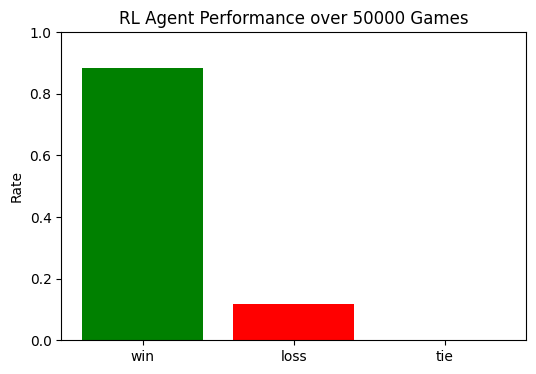

{'win': 0.88292, 'loss': 0.11704, 'tie': 4e-05}

In [ ]:
net.load_state_dict(torch.load("connect4_checkpoint_v1.pth"))
net.eval()

set_seed(42)
evaluate_win_rate(num_games=50000)

Below is the Connect Four code and the cell to initiate real-time play.

In [ ]:
# ansi colors
reset = "\033[0m"
red = "\033[31m"
yellow = "\033[33m"

#pieces
piece = "●"

#identifiers that we stored in the board
empty = " "
red_id   = "R"
yellow_id = "Y"

# width of each printed cell -- it was looking funky without explicitly stating cell width
cell_width = 3

def display_for(cell):
    if cell == red_id:
        return f"{red}{piece}{reset}"
    elif cell == yellow_id:
        return f"{yellow}{piece}{reset}"
    else:
        return " "

def game_board(board):

    cols = len(board[0])
    total_width = cols * (cell_width + 1) + 1  #for borders

    print("-" * total_width)
    for row in board:
        print("|", end="")
        for cell in row:
            left = (cell_width - 1) // 2
            right = cell_width - 1 - left

            vis = display_for(cell)
            print(" " * left + vis + " " * right + "|", end="")
        print("\n" + "-" * total_width)

    # print column numbers centered in the same width
    print(" ", end="")
    for c in range(cols):
        print(f"{str(c+1):^{cell_width}} ", end="")
    print("\n")

# drops a piece into a column bottom-up
def drop_piece(board, col, piece_id):
    for row in range(5, -1, -1):  # bottom up
        if board[row][col] == empty:
            board[row][col] = piece_id
            return True
    return False  # if the column is full

# checks for win
def check_win(board, player_id):
    ROWS = 6
    COLS = 7

    # horizontal
    for r in range(ROWS):
        for c in range(COLS - 3):
            if all(board[r][c+i] == player_id for i in range(4)):
                return True

    # vertical
    for r in range(ROWS - 3):
        for c in range(COLS):
            if all(board[r+i][c] == player_id for i in range(4)):
                return True

    # diagonal down
    for r in range(ROWS - 3):
        for c in range(COLS - 3):
            if all(board[r+i][c+i] == player_id for i in range(4)):
                return True

    # diagonal up
    for r in range(3, ROWS):
        for c in range(COLS - 3):
            if all(board[r-i][c+i] == player_id for i in range(4)):
                return True

    return False

# computer move
def computer_move(board):
    valid_cols = [c for c in range(7) if board[0][c] == empty]
    if valid_cols:
        col = random.choice(valid_cols)
        drop_piece(board, col, yellow_id)

def game_play():
    board = [[empty for _ in range(7)] for _ in range(6)]

    player1 = "Sophie (the queen)"
    player2 = "Putie"

    current_player = player1

    while True:
        game_board(board)

        if current_player == player1:
            while True:
                try:
                    col = int(input("Pick a column (1-7): ")) - 1
                except ValueError:
                    print("You tricky bastard that's not a number.")
                    continue

                if col not in range(7):
                    print("That column doesn't exist. Enter 1–7 please.")
                    continue

                if drop_piece(board, col, red_id):
                    break
                else:
                    print("That column is full :( try again.")
        else:
            computer_move(board)

        # check win
        player_id = red_id if current_player == player1 else yellow_id
        if check_win(board, player_id):
            game_board(board)
            print(f"{current_player} wins!")
            break

        # tie
        if all(board[0][c] != empty for c in range(7)):
            game_board(board)
            print("It's a tie!")
            break

        # swap turns
        current_player = player2 if current_player == player1 else player1

In [ ]:
game_play()

-----------------------------
|   |   |   |   |   |   |   |
-----------------------------
|   |   |   |   |   |   |   |
-----------------------------
|   |   |   |   |   |   |   |
-----------------------------
|   |   |   |   |   |   |   |
-----------------------------
|   |   |   |   |   |   |   |
-----------------------------
|   |   |   |   |   |   |   |
-----------------------------
  1   2   3   4   5   6   7  

Pick a column (1-7): 3
-----------------------------
|   |   |   |   |   |   |   |
-----------------------------
|   |   |   |   |   |   |   |
-----------------------------
|   |   |   |   |   |   |   |
-----------------------------
|   |   |   |   |   |   |   |
-----------------------------
|   |   |   |   |   |   |   |
-----------------------------
|   |   | ● |   |   |   |   |
-----------------------------
  1   2   3   4   5   6   7  

-----------------------------
|   |   |   |   |   |   |   |
-----------------------------
|   |   |   |   |   |   |   |
---------------

# **Challenges Encountered**:

**Network Architecture Tuning**:

Initial experiments with a single-layer network produced poor results:

* Challenge: Single hidden layer (42 -> 64 -> 7) achieved only ~60% win rate against random opponent, indicating insufficient ability to learn complex chessboard patterns.

* Solution: Expanded to two hidden layers (42 -> 100 -> 50 -> 7)

* Result: Win rate improved to ~88%, validating the need for deeper architecture

* Trade-off: More parameters increased training time but improved performance


**Insufficient Rewards**:

The Reinforce algorithm only provides feedback at game end:

* Challenge: A game might last 20-42 moves, but only the final outcome (+1, -1, or 0) guides learning. So is difficult for the agent to determine which specific moves were good or bad. For example, If the agent loses after 30 moves, should move 5, move 15, or move 28 be punished? So the current limitation is that the algorithm rewards/punished all moves equally based on final outcome. This contributes to slower learning and difficulty discovering subtle strategic patterns.

* Possible solutions: We considered adding intermediate rewards for "three-hit combos" or blocking the opponent, but we abandoned this approach to avoid affecting the learned strategies.

**Findings**:
The most significant finding is the performance plateau at ~88% win rate. Extended training from 10,000 to 100,000 episodes failed to improve performance, this may suggesting that:

1. Opponent Limitation: The random opponent creates a skill ceiling. The agent cannot learn beyond what random play teaches, as it never encounters multi-move traps or complex defensive patterns.

2. Architectural Constraints: The fully connected network architecture may not capture spatial relationships between board positions and temporal dependencies across moves. Convolutional neural networks (CNNs) might better recognize spatial patterns like diagonal threats or board control.

# **Discussion and Explanation of Analysis**

**Training Performance**

Over 100,000 training episodes, the agent demonstrated substantial learning:

* Wins: 44,146 (88.29%)
* Losses: 5,852 (11.70%)
* Ties: 2 (0.004%)

**Learning Progression**:

* Episodes 0-500: 88.2% win rate
* Episodes 10,000-10,500: 87.2% win rate
* Episodes 99,500-100,000: 88.29% win rate

The consistently high win rate throughout training (approximately 87-89%) shows that the agent quickly learned effective strategies against the random opponent.

**Evaluation Performance:**

Post-training evaluation over 10,000 independent games yielded:

* Win rate: 88.29%
* Loss rate: 11.70%
* Tie rate: 0.01%

The tie rate (0.01% in evaluation) suggests that games typically reach decisive conclusions, with either the agent or opponent establishing winning connections.

**Strategic Behavior Analysis**

Based on the training results, the agent likely learned several fundamental Connect 4 strategies:

* High win rate suggests effective identification of winning moves.
* The failure rate of approximately 12% indicates that there are occasional instances where blocking the opponent fails.
* Easiest winning pattern to learn.

**Comparison of Training vs. Evaluation Performance**
The training (win rate 89.34%) and evaluation (win rate 87.90%) performances are almost identical, indicating that the model does not overfit specific game sequences. The learned policy is stable and reproducible. And with 100,000+ games, the ~1.5% difference is likely within normal variance.

##**Comparison with Literature**
For Connect Four, our results most closely resemble the trends reported in the article Connect Four: Reinforcement Learning Approach by Brandon Leung (2018). In Leung’s experiments, win-rates against a random agent initially fluctuated heavily due to sparse rewards and the larger action space, then slowly climbed as the agent learned basic blocking and vertical strategies. Our results show the same pattern: long periods of noisy improvement followed by slow stabilization. Like Leung’s model, our agent struggled to reach consistently dominant play without additional heuristics. Our models had similar win rates, where his fluctuated between 80% and 95%, compared to our 88%.

And finally, our research brought us to a GitHub community project by Neo Yung that also contained an implementation of a reinforcement learning agent trained to play Connect Four. This work shows a much sharper improvement curve as Yung incorporates stronger heuristics, deeper networks, and more structured reward shaping. Compared to that system, our performance curve also follows the same qualitative trajectory—early instability, mid-training improvement, and late-training plateau. Our agent was able to achieve a win rate (88%) close to Yung's (about 92%) although Yung had trained for 20,000 games while our model was only trained for 10,000 games. Thus, our results in both Tic-Tac-Toe and Connect Four show clear parallels to findings reported in earlier DRL game-learning studies.

# **Conclusion:**

Across both Tic-Tac-Toe and Connect Four, this project demonstrates how deep reinforcement learning can acquire increasingly strategic behavior through structured self-play, iterative refinement, and careful architectural design. Starting with Tic-Tac-Toe allowed us to diagnose core DRL challenges—particularly perspective imbalance and sparse reward signals—before scaling to the more complex environment of Connect Four. Through a multi-phase training curriculum and deeper network design, the Tic-Tac-Toe agent ultimately achieved perfect defensive play, surpassing the performance reported  in simpler Q-learning implementations such as in the article by Kaneel Senevirathne (2021). His implementation did not reach fully symmetric, optimal strategies. Similarly, our Connect Four results, while strong against random opponents, align with findings from the article by Brandon Leung (2018) which also shows performance plateaus when using feed-forward networks and random-opponent training.

These comparisons reinforce a consistent pattern in the literature: DRL agents can learn effective tactics in structured board games, but architectural choices, opponent quality, and training regimen strongly determine whether agents progress beyond basic competence. Future progress will likely require more expressive architectures, stronger adversarial training, and richer reward structures. Overall, this project not only mirrors key trends reported in prior work but also highlights practical insights into how DRL agents learn, where they stall, and how training pipelines can be improved as strategic complexity increases.

# **Sources**:

Deep Reinforcement Learning (2021, September 21). | PNNL. (n.d.). Www.pnnl.gov.  
  https://www.pnnl.gov/explainer-articles/deep-reinforcement-learning

Fulton, S. (2025, June 11). Brighten Up Your Terminal with ANSI Codes. Medium.
https://medium.com/@fulton_shaun/brighten-up-your-terminal-with-ansi-codes-cb5f5d2ff085

GeeksforGeeks. (2020, May 5). Python random.choices() method. GeeksforGeeks.
https://www.geeksforgeeks.org/python/random-choices-method-in-python/

Kaili, G., & Liu, M. (n.d.). (2023, February 28). Perspectives on the Social Impacts of
Reinforcement Learning with Human Feedback. https://arxiv.org/pdf/2303.02891

Kaneel Senevirathne. (2021, August 12). Teaching agents to play tic-tac-toe using Reinforcement Learning. Medium. http://medium.com/@kaneel.senevirathne/teaching-agents-to-play-tic-tac-toe-using-reinforcement-learning-7a9d4d6ee9b3


Leung, B. (2020). Creating a Reinforcement Learning AI to play Connect Four. https://b7leung.github.io/files/Connect%20Four.pdf


Maynez, A. (2021, March 18). Deep Q Learning for Tic Tac Toe. The
Minimum Viable Model. https://the-mvm.github.io/deep-q-learning-tic-tac-toe.html

Merchán, E. C. G. (2023, October 18). Why deep reinforcement learning is going to be the next
big deal in AI. Medium. https://medium.com/@eduardogarrido90/why-deep-reinforcement-learning-is-going-to-be-the-next-big-deal-in-ai-2e796bdf47d2

Mikulski, B. (2019, July 19). Bellman Equation Explained: The Foundation of Reinforcement Learning Algorithms. https://mikulskibartosz.name/bellman-equation-explained


Neo Yung. (2025). A reinforcement learning agent trained without prior human knowledge. GitHub. https://github.com/neoyung/connect-4


Raveaux, R. (2025). Reinforcement Learning by QLearning - Connect Four. Free.fr. http://romain.raveaux.free.fr/document/ReinforcementLearningbyQLearningConnectFourGame.html

Tic-Tac-Toe with a Neural Network. (2019, December 27). Nestedsoftware.com. https://nestedsoftware.com/2019/12/27/tic-tac-toe-with-a-neural-network-1fjn.206436.html

Whittlestone, J., Arulkumaran, K., & Crosby, M. (2021, March 8). The Societal Implications of
Deep Reinforcement Learning. Journal of Artificial Intelligence Research, 70. https://doi.org/10.1613/jair.1.12360


Yadav, A. (2024, September 20). Tic-Tac-Toe Reinforcement Learning Project. Medium; Biased-Algorithms.
https://medium.com/biased-algorithms/tic-tac-toe-reinforcement-learning-project-23f015711f0d



